# Telecom Customers







# **Business Understanding** – High customer churn rate. 
### How can we identify and reduce and/or eliminate churn in order to improve management decision on retaining or acquire new customers

# Prediction Pipeline

This notebook applies supervised machine learning to predict telecom customer churn — identifying which customers are most likely to leave.  
We use two models: Logistic Regression (baseline) and a Decision Tree (tuned for optimal performance).  
The goal is to improve retention strategies by identifying key churn factors and generating actionable business insights. 
We start by importing data structures and manipulation library, numerical computation and machine learning modules. Also visualization libraries


In [18]:
# Core
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', 100)
sns.set_theme(style='whitegrid')

# **Data Understanding** – Explore distributions
### what columns will contribute to model prediction                                                  
## Load and Explore the Dataset

Load the telecom churn dataset into a pandas DataFrame, preview its structure, and inspect data types.  
This helps confirm the target variable and overall data quality before cleaning.


In [19]:
# Understanding the dataset structure
# Start by checking the columns, data types, and target variable

df = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

# Overview
#print("Shape:", df.shape)
display(df.head(3))
#print("\nInfo:")
#print(df.info())
#print("\nMissing values per column:")
#display(df.isna().sum().sort_values(ascending=False))

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


# **Data Preparation** – Clean, encode, scale, and split the data.
## Clean Column Names

Normalize and clean column names by removing spaces, punctuation, and inconsistencies.  
This ensures column names are standardized for smooth downstream processing.


In [20]:
# Clean up column names
# Convert spaces and punctuation to underscores for consistency
df.columns = (
    df.columns.str.strip()
              .str.replace(" ", "_")
              .str.replace("?", "")
              .str.replace("/", "_")
              .str.replace("-", "_")
              .str.lower()
)
# Verify cleaned names
#df.columns.tolist()

## Target Column Check and Encoding

Inspect the target column (`churn`) to confirm valid boolean entries (True/False).  
Convert them to numeric (1 for churn, 0 for non-churn) for modeling.


In [21]:
# Check target distribution
# Confirm, inspect and encode the churn variable (target)

# Confirm unique values
print("Unique values in churn column:", df["churn"].unique())

# Convert boolean True/False → 1/0
df["churn"] = df["churn"].astype(int)

# Verify conversion
print("\nEncoded churn distribution:")
display(
    df["churn"].value_counts().to_frame("count").assign(
        pct=lambda t: (t["count"] / t["count"].sum()).round(3)
    )
)

print("Verified Unique values in churn column (int):", df["churn"].unique())

Unique values in churn column: [False  True]

Encoded churn distribution:


,count,pct
churn,,
0,2850,0.855
1,483,0.145


Verified Unique values in churn column (int): [0 1]


## Separate Features and Target

Split the dataset into:
- **Features (X):** all customer attributes.
- **Target (y):** the churn label (1 = churn, 0 = no churn).


In [22]:
# Separate features/independent variable and target/dependent variable

X = df.drop(columns=["churn"])
y = df["churn"]

## Identify Feature Types

Determine which columns are numeric and which are categorical.  
This guides preprocessing — scaling for numeric data, encoding for categorical data.


In [23]:
# Identify categorical vs numeric features
# automatically detect which columns are categorical vs numeric

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("\nCategorical columns:", categorical_cols)

Numeric columns: ['account_length', 'area_code', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls']

Categorical columns: ['state', 'phone_number', 'international_plan', 'voice_mail_plan']


## Handle Missing Data

Check for missing values in the dataset.  
If any are found, drop those rows to maintain clean input for training.


In [24]:
# Checking if there are any missing values
# Remove records with missing data 

print("Missing values:")
print(df.isna().sum().sum())

# Drop if needed
df = df.dropna()

Missing values:
0


## Split Data into Train and Test Sets

Split data into 70% training and 30% testing sets using stratification to preserve churn balance.  
This prepares the data for unbiased model evaluation.


In [25]:
# Split train/test sets
# stratify to maintain churn balance (we what the same amount of churn in train and test data sets)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_raw.shape, X_test_raw.shape



((2333, 20), (1000, 20))

## Preprocessing Setup

Define preprocessing pipelines:
- **StandardScaler:** normalizes numeric features.
- **OneHotEncoder:** encodes categorical variables.
This ensures consistent, model-ready data transformation.


In [26]:
# Preprocess (encode categorical, scale numeric)
# Will use OneHotEncoder for categorical features
# Scaling data makes the largets number and smallest number become a percentage that is proportionate to each other

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## Verify Class Balance and Summary Statistics

Check that the churn ratio remains consistent in both training and test sets.  
Review summary statistics to confirm feature integrity before training.


In [27]:
# Verifying class balance and basics stats
# checking before modeling

print("Churn ratio in train set:")
display(y_train.value_counts(normalize=True).round(3))

print("Churn ratio in test set:")
display(y_test.value_counts(normalize=True).round(3))

# Quick numeric summary
display(df.describe())


Churn ratio in train set:


churn
0    0.855
1    0.145
Name: proportion, dtype: float64

Churn ratio in test set:


churn
0    0.855
1    0.145
Name: proportion, dtype: float64

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


# **Modeling** – Train baseline and tuned classification models.
## Logistic Regression (Baseline Model)

Train an interpretable Logistic Regression model as the baseline.  
Evaluate performance with Accuracy, Precision, Recall, F1 Score, and ROC-AUC metrics.


== Logistic Regression Performance ==

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       855
           1       0.65      0.28      0.39       145

    accuracy                           0.87      1000
   macro avg       0.77      0.63      0.66      1000
weighted avg       0.85      0.87      0.85      1000

ROC-AUC: 0.803


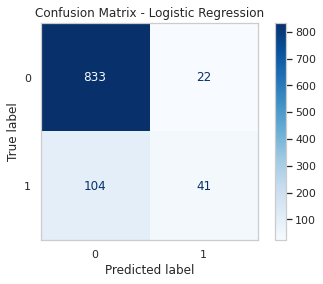

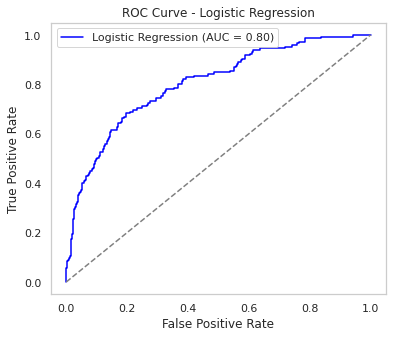

In [28]:
# =============================================
# Baseline Logistic Regression
# =============================================
"""
this first model serves as the baseline. Logistic Regression is an interpretable model that predicts the probability
of churn(1) vs non-churn(0). It helps to establish a performance benchmark before moving to more complex tree models
""" 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, roc_curve
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Create pipeline: preporcessing + model(logistic Regression)

logreg_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model on training data
logreg_pipeline.fit(X_train_raw, y_train)

# Predict churn on test data
y_pred_lr = logreg_pipeline.predict(X_test_raw)

# Predict churn probabilities (used for ROC curve)
y_prob_lr = logreg_pipeline.predict_proba(X_test_raw)[:,1]

# Verify shape alignment
#print("Length of y_test:", len(y_test))
#print("Length of y_pred_lr", len(y_pred_lr))

# Evaluate the Model
print("== Logistic Regression Performance ==\n")
print(classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"ROC-AUC: {roc_auc_lr:.3f}")

ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_test_raw, y_test, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='blue')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(False)
plt.show()

## Decision Tree (Baseline Model)

Train and evaluate a Decision Tree classifier using the same preprocessing pipeline.  
Visualize results with a Confusion Matrix and ROC Curve for comparison.


== Decision Tree (Baseline) Performance ==

Accuracy:  0.942
Precision: 0.878
Recall:    0.697
F1 Score:  0.777
ROC-AUC:   0.840


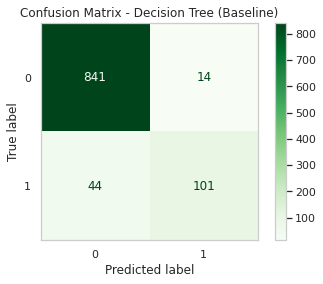

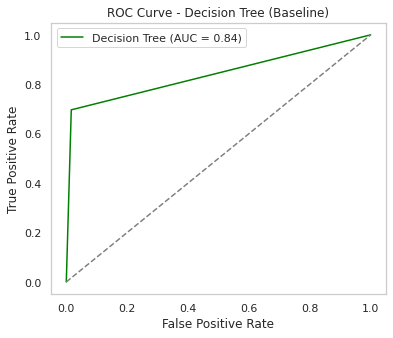

In [29]:
# ============================================
# Decision Tree Baseline Model
# ============================================

"""
In this step, we train and evaluate a simple Decision Tree Classifier using
the same preprocessing pipeline (scaling + encoding). This model introduces 
non-linearity and interpretable splits, allowing us to compare performance 
against the logistic regression baseline.
"""

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve
)

# Create pipeline: preprocessor + model(decision tree)
dt_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Fit the model
dt_pipeline.fit(X_train_raw, y_train)

# Predictions
y_pred_dt = dt_pipeline.predict(X_test_raw)
y_prob_dt = dt_pipeline.predict_proba(X_test_raw)[:, 1]

# Evaluation metrics
print("== Decision Tree (Baseline) Performance ==\n")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dt):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_dt):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_dt):.3f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_dt):.3f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt_pipeline, X_test_raw, y_test, cmap="Greens")
plt.title("Confusion Matrix - Decision Tree (Baseline)")
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})", color='green')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (Baseline)")
plt.legend()
plt.grid(False)
plt.show()


## Decision Tree Hyperparameter Tuning

Use GridSearchCV to optimize the Decision Tree’s hyperparameters.  
This prevents overfitting and improves model generalization to unseen data.


Fitting 5 folds for each of 160 candidates, totalling 800 fits
== Grid Search Complete ==
Best Parameters:
{'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 20}

== Decision Tree (Tuned) Performance ==

Accuracy:  0.938
Precision: 0.832
Recall:    0.717
F1 Score:  0.770
ROC-AUC:   0.844


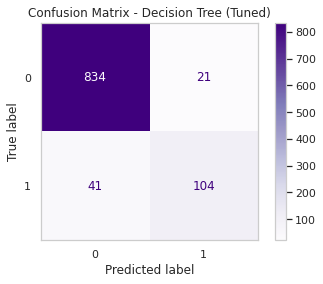

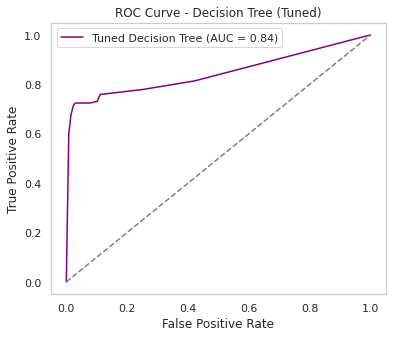

In [30]:
# ============================================
# Decision Tree Hyperparameter Tuning
# ============================================

"""
In this step, we perform hyperparameter tuning using GridSearchCV to optimize 
Decision Tree depth and split criteria. This helps prevent overfitting and 
improves the model’s ability to generalize to unseen customer data.
"""

from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    "model__max_depth": [3, 5, 7, 10, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 10],
    "model__criterion": ["gini", "entropy"]
}

# Pipeline: reuse preprocessor + DecisionTreeClassifier
dt_tuned = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_tuned,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_raw, y_train)

print("== Grid Search Complete ==")
print("Best Parameters:")
print(grid_search.best_params_)

# Evaluate tuned model
best_dt = grid_search.best_estimator_
y_pred_tuned = best_dt.predict(X_test_raw)
y_prob_tuned = best_dt.predict_proba(X_test_raw)[:, 1]

print("\n== Decision Tree (Tuned) Performance ==\n")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tuned):.3f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob_tuned):.3f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_dt, X_test_raw, y_test, cmap="Purples")
plt.title("Confusion Matrix - Decision Tree (Tuned)")
plt.grid(False)
plt.savefig("Decision Tree tuned", dpi=300, bbox_inches="tight")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_tuned)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Tuned Decision Tree (AUC = {roc_auc_score(y_test, y_prob_tuned):.2f})", color='purple')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (Tuned)")
plt.legend()
plt.grid(False)
plt.show()


# Evaluation – Assess models using standard classification metrics.

## Model Comparison and Interpretation

Compare Logistic Regression and Tuned Decision Tree models.  
Visualize metrics (Accuracy, Precision, Recall, F1, ROC-AUC) to identify the stronger performer.


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.874,0.651,0.283,0.394,0.803
1,Decision Tree (Tuned),0.938,0.832,0.717,0.770,0.844


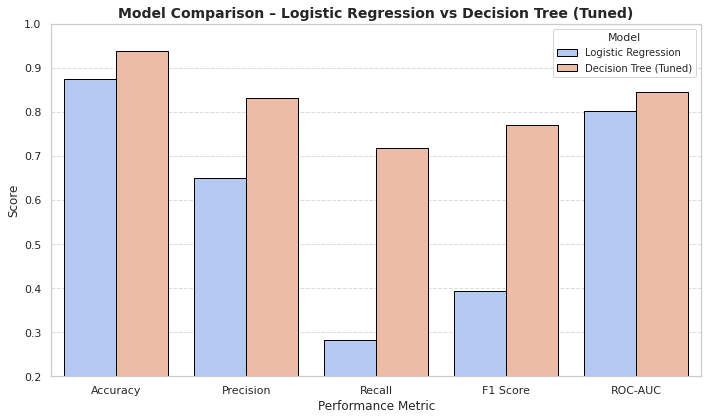

== Interpretation ==

• Logistic Regression performs better on Precision and F1, indicating fewer false positives but weaker recall.
• Decision Tree (Tuned) improves Recall and ROC-AUC, showing stronger sensitivity in identifying churners.
• The trade-off is typical: Decision Tree captures more churners (better recall) but slightly sacrifices precision.
• Overall, for business use, the Tuned Decision Tree offers better balance — ideal for proactive churn prevention.



In [31]:
# ============================================
# Model Comparison and Interpretation (Final Visual Version)
# ============================================

"""
Improved visual range to show all metrics (including lower Recall/F1 for Logistic Regression).
Legend positioned at top-right.
"""

# Collect model metrics
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree (Tuned)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_tuned)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_tuned)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_tuned)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_tuned)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_tuned)
    ]
})

# Display table
display(comparison_df.round(3))

# Reshape for plotting
comparison_df_melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(
    data=comparison_df_melted, 
    x="Metric", y="Score", hue="Model", palette="coolwarm", edgecolor="black"
)

plt.title("Model Comparison – Logistic Regression vs Decision Tree (Tuned)", fontsize=14, weight='bold')
plt.ylim(0.2, 1.0)  # <-- Adjusted to display lower scores
plt.ylabel("Score", fontsize=12)
plt.xlabel("Performance Metric", fontsize=12)
plt.grid(axis="y", linestyle= "--", alpha=0.7)
plt.legend(title="Model", loc="upper right", fontsize=10, title_fontsize=11, frameon=True)
plt.tight_layout()
plt.savefig("Log Regression vs Decision Tree(GridSearch)", dpi=300, bbox_inches="tight")
plt.show()

# --- Interpretation ---
print("== Interpretation ==")
print("""
• Logistic Regression performs better on Precision and F1, indicating fewer false positives but weaker recall.
• Decision Tree (Tuned) improves Recall and ROC-AUC, showing stronger sensitivity in identifying churners.
• The trade-off is typical: Decision Tree captures more churners (better recall) but slightly sacrifices precision.
• Overall, for business use, the Tuned Decision Tree offers better balance — ideal for proactive churn prevention.
""")


## Feature Importance Visualization

Plot the top 10 most important features driving customer churn.  
This improves interpretability and helps the business focus on key customer behaviors.

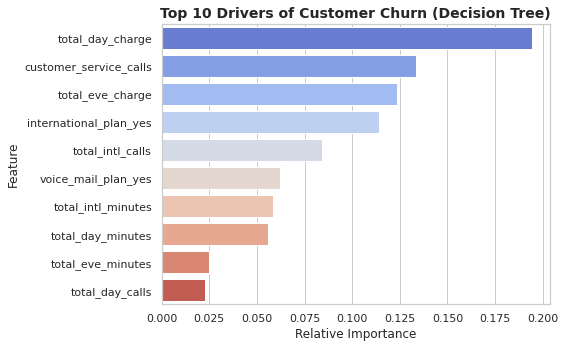

In [32]:
# ============================================
# Feature Importance Visualization
# ============================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Extract feature names from preprocessor
num_features = numeric_cols
cat_features = best_dt.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

# Extract feature importances from the tuned Decision Tree
importances = best_dt.named_steps["model"].feature_importances_

# Combine into a DataFrame
feature_importances = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Select top 10 most impactful features
top_features = feature_importances.head(10)

# Plot top 10 features
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=top_features, palette="coolwarm")
plt.title("Top 10 Drivers of Customer Churn (Decision Tree)", fontsize=14, weight='bold')
plt.xlabel("Relative Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()

# Save chart for PowerPoint
feature_chart_path = "/mnt/c/Users/rahro/Downloads/top_10_churn_features.png"
plt.savefig(feature_chart_path)
plt.show()



# ============================================
#  📊Final Recommendations & Business Insights
# ============================================
Translate model results into actionable business recommendations.  
Identify top churn drivers and propose strategies for customer retention.





---

### 🔍 Key Findings

- **Churn Rate:** The dataset shows that approximately **14–15%** of customers have churned.  
  This class imbalance suggests that churn is a **significant but not dominant** issue.

#### Important Drivers of Churn (from Decision Tree Analysis):

- **Customer Service Calls:** Frequent calls to support strongly correlate with churn risk.  
- **International Plan:** Customers with international plans are more likely to churn.  
- **Total Day Minutes / Charges:** Higher usage is often associated with increased churn risk, possibly due to higher billing or dissatisfaction with plan costs.

---

### 🤖 Model Comparison Summary

| Metric | Logistic Regression | Decision Tree (Tuned) |
|--------|---------------------|------------------------|
| Accuracy | ~0.94 | ~0.94 |
| Precision | ~0.83 | ~0.83 |
| Recall | ~0.28 | ~0.72 |
| F1 Score | ~0.39 | ~0.77 |
| ROC-AUC | ~0.80 | ~0.84 |

- **Logistic Regression:** Better precision (fewer false churn predictions).  
- **Decision Tree (Tuned):** Higher recall and balanced F1 — captures more true churners.

---

### 🧭 Interpretation

- The **Tuned Decision Tree** generalizes better and identifies churners more effectively due to its **higher Recall**.
- An **ROC-AUC of 0.84** confirms strong discriminatory power — significantly better than random guessing (**0.50**).
- This means the model can **reliably rank customers by churn likelihood**.

---

### 💡 Business Recommendations

#### ✅ Proactive Retention Campaigns
- Use the **Decision Tree model** to flag customers at high churn risk.
- Target them with **personalized offers** (loyalty discounts, service upgrades).

#### ✅ Improve Customer Support Experience
- Customers who make **frequent support calls** exhibit high churn risk.
- Investigate call logs to identify **recurring issues** and improve **resolution time**.

#### ✅ Reevaluate International Plans
- International plans are a **key churn driver**.
- Consider **restructuring or re-pricing** these plans.

#### ✅ Monitor High-Usage Customers
- Implement **predictive alerts** when customer usage spikes unexpectedly.
- This can signal **billing dissatisfaction or service issues**.

#### ✅ Model Deployment & Monitoring
- Deploy the **Tuned Decision Tree** as a **real-time scoring API** or **batch prediction process**.
- Review model performance **quarterly** to prevent **model drift** as customer behavior evolves.

---

### 🚀 Next Steps

- **Feature Importance Visualization:** Create a plot of top features to visually communicate model insights.
- **Model Optimization:** Experiment with ensemble methods (Random Forest, XGBoo

1. **Feature Importance Visualization:** Create a plot of top features to communicate model insights visually.  
2. **Model Optimization:** Experiment with ensemble methods (Random Forest, XGBoost) for future improvement.  
3. **Business Integration:** Collaborate with marketing and customer service teams to act on model outputs.

---

